# Data Gathering (Web-Scraping)

In [ ]:
import csv
import requests
from bs4 import BeautifulSoup

def get_reviews(soup):
    return soup.find_all('div', class_='review-container')

def extract_review_info(review):
    try:
        reviewer_name = review.find('span', class_='display-name-link').text.strip()
    except AttributeError:
        reviewer_name = None
    try:
        rating = review.find('span', class_='rating-other-user-rating')
        rating = rating.find('span').text.strip() if rating else None
    except AttributeError:
        rating = None
    try:
        title = review.find('a', class_='title').text.strip()
    except AttributeError:
        title = None
    try:
        review_text = review.find('div', class_='text').text.strip()
    except AttributeError:
        review_text = None
    
    return {
        'ProfileName': reviewer_name,
        'Score': rating,
        'Title': title,
        'Text': review_text
    }

url = "https://www.imdb.com/title/tt11057302/reviews/?ref_=ttrt_sa_3"

# Send a GET request to the IMDb page
response = requests.get(url)
soup = BeautifulSoup(response.content, 'html.parser')

# Extract the reviews
reviews = get_reviews(soup)

# Extract the header information
header = ['ProfileName', 'Score', 'Title', 'Text']

# Initialize the CSV file
with open('mw_user_reviews.csv', 'w', newline='', encoding='utf-8') as csvfile:
    writer = csv.DictWriter(csvfile, fieldnames=header)
    writer.writeheader()

    # Initialize a set to keep track of seen reviews
    seen_reviews = set()

    # Iterate through the reviews
    for review in reviews:
        review_dict = extract_review_info(review)
        review_key = tuple(review_dict.values())  # Create a unique key for the review
        if review_key not in seen_reviews:
            writer.writerow(review_dict)
            seen_reviews.add(review_key)

    # Load more reviews
    load_more_url = "https://www.imdb.com/title/tt11057302/reviews/_ajax"
    params = {
        'paginationKey': '',
        'ref_': 'undefined',
        'sort': 'helpfulnessScore',
        'dir': 'desc',
        'ratingFilter': ''
    }

    while True:
        response = requests.post(load_more_url, params=params)
        soup = BeautifulSoup(response.content, 'html.parser')
        new_reviews = get_reviews(soup)

        if not new_reviews:
            break

        for review in new_reviews:
            review_dict = extract_review_info(review)
            review_key = tuple(review_dict.values())  # Create a unique key for the review
            if review_key not in seen_reviews:
                writer.writerow(review_dict)
                seen_reviews.add(review_key)

        # Update the pagination key
        load_more_data = soup.find('div', class_='load-more-data')
        if load_more_data:
            params['paginationKey'] = load_more_data['data-key']
        else:
            break

## Read Dataset

In [1]:
import pandas as pd

In [2]:
# Load the dataset
data = pd.read_csv('mw_user_reviews.csv', nrows=1000)

# Preview the head of the data
data.head()

,ProfileName,Score,Title,Text
0,eoinageary,3.0,Yikes,"This is, well I guess this is a movie in the S..."
1,sinscopefilms,3.0,I regret watching this film,First Impression:The opening of the Madame Web...
2,syntory,2.0,How are bad writers able to continually get hi...,Look at the profiles for the writers that wrot...
3,MovieWarfare,1.0,Makes Morbius look like The Dark Knight,I would absolutely love to be in these Sony me...
4,johnnychicago-75285,6.0,Not as bad as most people claim...,I don't understand what the big problem is. Ye...


# Text Preprocessing 

In [3]:
# Select Score and Text column only
data = data[['Score', 'Text']]

In [4]:
# Find the number of duplicated rows
duplicate_text = data.duplicated()
print(duplicate_text.sum())

0


In [5]:
# Remove the duplicated rows except the first one
data = data.drop_duplicates(keep='first')
data.shape

(1000, 2)

In [6]:
# Check any rows available
print(data) 

     Score                                               Text
0      3.0  This is, well I guess this is a movie in the S...
1      3.0  First Impression:The opening of the Madame Web...
2      2.0  Look at the profiles for the writers that wrot...
3      1.0  I would absolutely love to be in these Sony me...
4      6.0  I don't understand what the big problem is. Ye...
..     ...                                                ...
995    8.0  Finally a film from Marvel that is not just ab...
996   10.0  "Madame Web" stands as a bold, if not entirely...
997   10.0  I just finished watching Madame Web with a gre...
998    8.0  Listen, this movie is NOT an action-packed sup...
999   10.0  This movie was wonderful, it was action packed...

[1000 rows x 2 columns]


## Cleaning & Standardization

In [7]:
import re

def clean_text(text):
    # Remove HTML tags
    cleaned_text = re.sub(r'<.*?>', '', text)
    
    # Remove URLs
    cleaned_text = re.sub(r'http\S+', '', cleaned_text)
    
    # Remove special characters and digits
    cleaned_text = re.sub(r'[^a-zA-Z\s]', '', cleaned_text)
    
    # Convert to lowercase
    cleaned_text = cleaned_text.lower()
    
    # Remove extra whitespaces
    cleaned_text = re.sub(r'\s+', ' ', cleaned_text)
    
    return cleaned_text.strip()

# Apply the clean_text function to the 'Text' column
data['Text'] = data['Text'].apply(clean_text)

# View the cleaned text data
data.head()


,Score,Text
0,3.0,this is well i guess this is a movie in the so...
1,3.0,first impressionthe opening of the madame web ...
2,2.0,look at the profiles for the writers that wrot...
3,1.0,i would absolutely love to be in these sony me...
4,6.0,i dont understand what the big problem is yes ...


In [8]:
# Check for missing values
data.isnull().sum()

Score    8
Text     0
dtype: int64

In [9]:
# Remove rows with missing 'Score' value
data = data.dropna(subset=['Score'])

In [10]:
# Check for missing values
data.isnull().sum()

Score    0
Text     0
dtype: int64

In [11]:
# Select relevant columns for sentiment analysis
data = data[['Score', 'Text']]

## Tokenization & Stopword Removal

In [12]:
import nltk
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer

nltk.download('punkt')
nltk.download('stopwords')

def tokenize_text(text):
    tokens = nltk.word_tokenize(text)
    stop_words = set(stopwords.words('english'))
    filtered_tokens = [token for token in tokens if token.lower() not in stop_words]
    return filtered_tokens

# Tokenize the text into individual words
data['Tokens'] = data['Text'].apply(tokenize_text)


[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\Administrator\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\Administrator\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


## Lemmatization 

In [13]:
# Download the WordNet lemmatizer
nltk.download('wordnet')

[nltk_data] Downloading package wordnet to
[nltk_data]     C:\Users\Administrator\AppData\Roaming\nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


True

In [14]:
# Initialize the WordNet lemmatizer
lemmatizer = WordNetLemmatizer()

# Lemmatize the tokens
data['Tokens'] = data['Tokens'].apply(lambda x: [lemmatizer.lemmatize(word) for word in x])

In [15]:
# Join the tokens back into sentences
data['Preprocessed_Text'] = data['Tokens'].apply(lambda x: ' '.join(x))

# Save the preprocessed data to a new CSV file
data.to_csv('processed.csv', index=False)

# Preview the preprocessed data
print(data)

     Score                                               Text  \
0      3.0  this is well i guess this is a movie in the so...   
1      3.0  first impressionthe opening of the madame web ...   
2      2.0  look at the profiles for the writers that wrot...   
3      1.0  i would absolutely love to be in these sony me...   
4      6.0  i dont understand what the big problem is yes ...   
..     ...                                                ...   
995    8.0  finally a film from marvel that is not just ab...   
996   10.0  madame web stands as a bold if not entirely su...   
997   10.0  i just finished watching madame web with a gre...   
998    8.0  listen this movie is not an actionpacked super...   
999   10.0  this movie was wonderful it was action packed ...   

                                                Tokens  \
0    [well, guess, movie, sony, universe, im, shock...   
1    [first, impressionthe, opening, madame, web, i...   
2    [look, profile, writer, wrote, madame, w

# Heatmap

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\Administrator\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\Administrator\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package wordnet to
[nltk_data]     C:\Users\Administrator\AppData\Roaming\nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


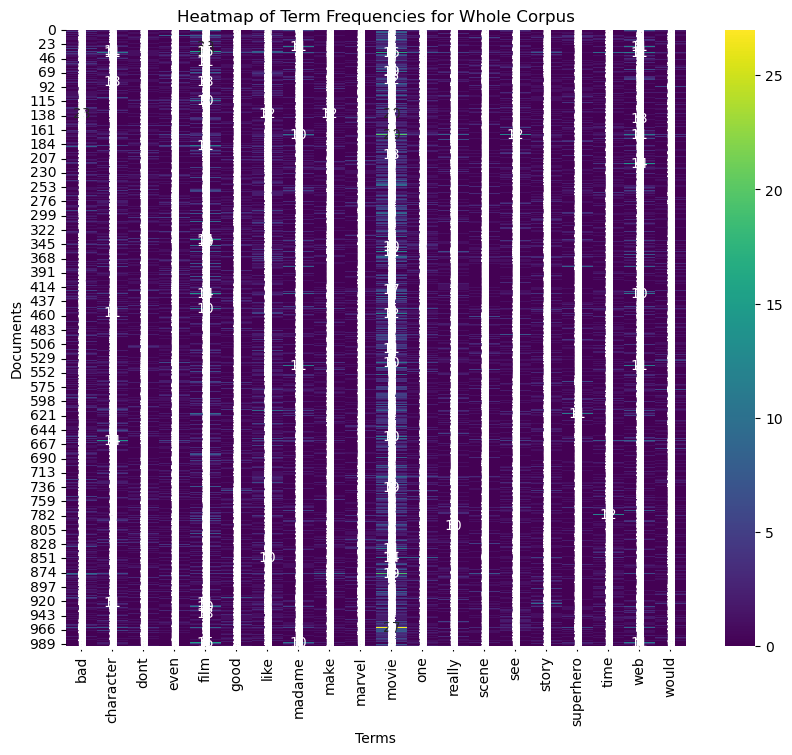

In [16]:
import pandas as pd
import re
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from nltk.stem import PorterStemmer, WordNetLemmatizer
import nltk
from IPython.display import display
from sklearn.feature_extraction.text import CountVectorizer
import matplotlib.pyplot as plt
import seaborn as sns

# Download NLTK resources
nltk.download('stopwords')
nltk.download('punkt')
nltk.download('wordnet')

vectorizer = CountVectorizer(max_features=20)
X = vectorizer.fit_transform(data['Preprocessed_Text'])
term_freq_matrix = X.toarray()
terms = vectorizer.get_feature_names_out()

# Create Heatmap
plt.figure(figsize=(10, 8))
sns.heatmap(term_freq_matrix, xticklabels=terms, cmap='viridis', annot=True)
plt.title("Heatmap of Term Frequencies for Whole Corpus")
plt.xlabel("Terms")
plt.ylabel("Documents")
plt.show()

# WorldCloud

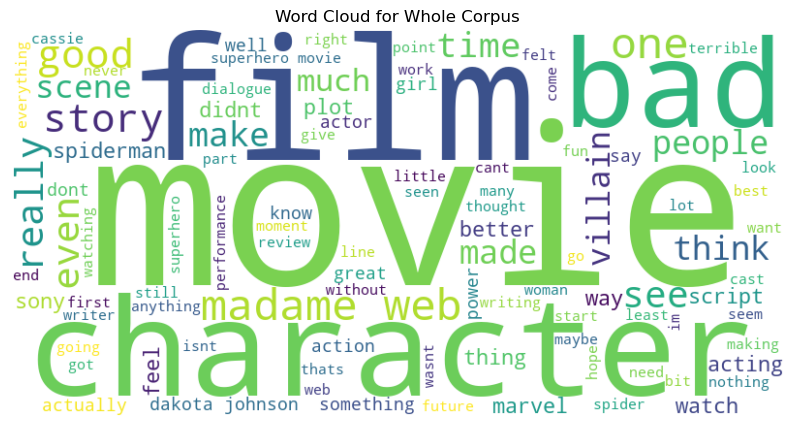

In [17]:
from wordcloud import WordCloud
all_text = " ".join(data['Preprocessed_Text'])
wordcloud = WordCloud(width=800, height=400, max_words=100, background_color='white').generate(all_text)
plt.figure(figsize=(10, 8))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis('off')
plt.title("Word Cloud for Whole Corpus")
plt.show()

# WorldCloud Divided by Sentiments

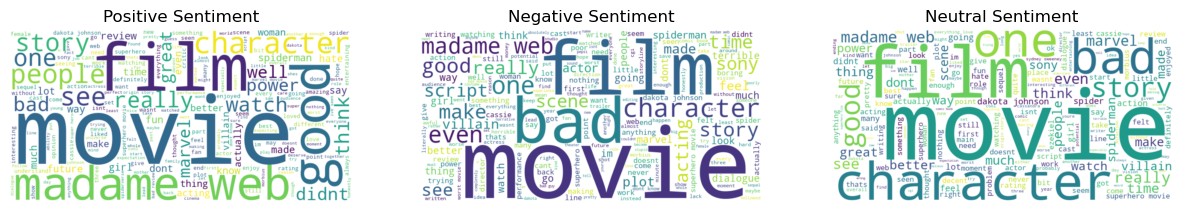

In [18]:
# Define the function to assign sentiment
data['Sentiment'] = data['Score'].apply(lambda score: 'Positive' if score >= 7 else ('Negative' if score <= 3 else 'Neutral'))

# Generate word cloud for positive sentiment
positive_text = ' '.join(data[data['Sentiment'] == 'Positive']['Preprocessed_Text'])
positive_wordcloud = WordCloud(width=800, height=400, background_color='white').generate(positive_text)

# Generate word cloud for negative sentiment
negative_text = ' '.join(data[data['Sentiment'] == 'Negative']['Preprocessed_Text'])
negative_wordcloud = WordCloud(width=800, height=400, background_color='white').generate(negative_text)

# Generate word cloud for neutral sentiment
neutral_text = ' '.join(data[data['Sentiment'] == 'Neutral']['Preprocessed_Text'])
neutral_wordcloud = WordCloud(width=800, height=400, background_color='white').generate(neutral_text)

# Display the word clouds
plt.figure(figsize=(15, 5))

plt.subplot(1, 3, 1)
plt.imshow(positive_wordcloud, interpolation='bilinear')
plt.title('Positive Sentiment')
plt.axis('off')

plt.subplot(1, 3, 2)
plt.imshow(negative_wordcloud, interpolation='bilinear')
plt.title('Negative Sentiment')
plt.axis('off')

plt.subplot(1, 3, 3)
plt.imshow(neutral_wordcloud, interpolation='bilinear')
plt.title('Neutral Sentiment')
plt.axis('off')

plt.show()

In [19]:
data['Sentiment'] = data['Score'].apply(lambda score: 'Positive' if score >= 7 else ('Negative' if score <= 3 else 'Neutral'))

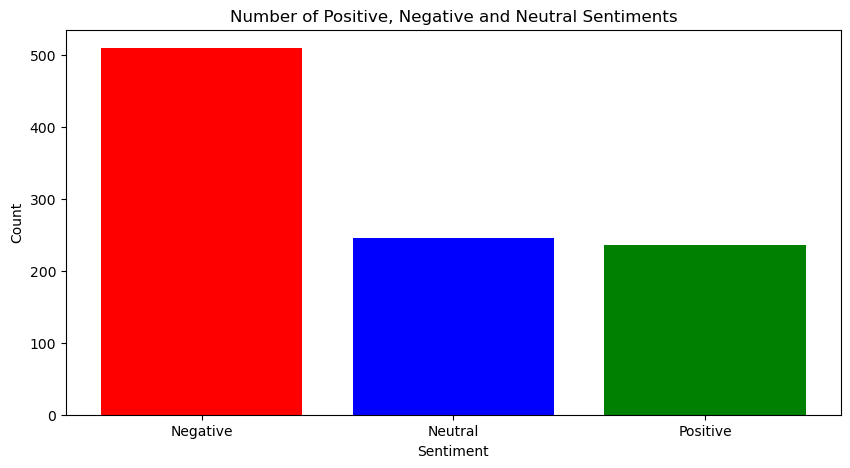

In [20]:
sentiment_counts = data['Sentiment'].value_counts()
plt.figure(figsize=(10, 5))
plt.bar(sentiment_counts.index, sentiment_counts.values, color=['red', 'blue', 'green'])
plt.title('Number of Positive, Negative and Neutral Sentiments')
plt.xlabel('Sentiment')
plt.ylabel('Count')
plt.show()

## Bag of Words

In [21]:
from sklearn.feature_extraction.text import CountVectorizer

# Initialize the CountVectorizer
vectorizer = CountVectorizer()

# Fit and transform the preprocessed text data
bow_features = vectorizer.fit_transform(data['Preprocessed_Text'])

# Get the vocabulary (unique words)
vocabulary = vectorizer.get_feature_names_out()

# Print the shape of the BoW features and the vocabulary size
print("Bag of Words (BoW) feature shape:", bow_features.shape)
print("Vocabulary size:", len(vocabulary))


Bag of Words (BoW) feature shape: (992, 12183)
Vocabulary size: 12183


## TF-IDF

In [22]:
import pandas as pd
import math
from collections import Counter

def compute_tf(document):
    word_count = Counter(document)
    tf = {word: count/len(document) for word, count in word_count.items()}
    return tf

def compute_idf(documents):
    N = len(documents)
    idf = {}
    all_words = set(word for doc in documents for word in doc)
    for word in all_words:
        count = sum(1 for doc in documents if word in doc)
        idf[word] = math.log(N/count)
    return idf

def compute_tfidf(document, idf):
    tfidf = {}
    tf = compute_tf(document)
    for word, tf_value in tf.items():
        tfidf[word] = tf_value * idf[word]
    return tfidf

# Split data into tokens
documents = [doc.split() for doc in data['Preprocessed_Text']]

# Compute TF for each document
tf_data = [compute_tf(doc) for doc in documents]

# Create DataFrame for TF
tf_df = pd.DataFrame(tf_data).fillna(0)
print("TF Scores:")
print(tf_df)

# Compute IDF
idf = compute_idf(documents)
idf_df = pd.DataFrame([idf]).fillna(0)
print("\nIDF Scores:")
print(idf_df)

# Compute TF-IDF for each document
tfidf_data = [compute_tfidf(doc, idf) for doc in documents]

# Create DataFrame for TF-IDF
tfidf_df = pd.DataFrame(tfidf_data).fillna(0)
print("\nTF-IDF Scores:")
print(tfidf_df)

TF Scores:
         well     guess     movie      sony  universe        im   shocked  \
0    0.009259  0.009259  0.027778  0.009259  0.009259  0.009259  0.009259   
1    0.000000  0.000000  0.003215  0.000000  0.000000  0.000000  0.000000   
2    0.000000  0.000000  0.090909  0.000000  0.000000  0.012987  0.012987   
3    0.000000  0.000000  0.032258  0.016129  0.000000  0.000000  0.000000   
4    0.000000  0.000000  0.130435  0.000000  0.000000  0.014493  0.000000   
..        ...       ...       ...       ...       ...       ...       ...   
987  0.000000  0.000000  0.000000  0.000000  0.000000  0.017241  0.000000   
988  0.000000  0.000000  0.000000  0.000000  0.016484  0.000000  0.000000   
989  0.000000  0.000000  0.008621  0.000000  0.000000  0.000000  0.000000   
990  0.016393  0.000000  0.114754  0.000000  0.000000  0.000000  0.000000   
991  0.000000  0.000000  0.053571  0.000000  0.000000  0.000000  0.000000   

     profitablethe     story     place  ...   client  intentions

# Model Selection

In [23]:
from nltk.sentiment import SentimentIntensityAnalyzer
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.naive_bayes import MultinomialNB
from sklearn.svm import LinearSVC
from sklearn.metrics import accuracy_score, classification_report

In [24]:
mystring=' '
for x in data['Preprocessed_Text']:
    mystring +=' '+ x
print(mystring)

  well guess movie sony universe im shocked profitablethe story place basically madame web paramedic develops power see future current threat try change future teaming powerful character yet develop full potential must shield change future protect themtrying give little story get told away opening vaguewhat liked one two good scene didnt mind end really liked lot camera work cool looking shot decent scorebut movie bad make morbius look like batman acting lacking actor look bored feel script bad beyond silly line story chop change much neck hurt bad cgi boring actionand people harp dont like woman lead crap film enjoyed marvel black widow decent movie regardless lead poorextremely disappointing first impressionthe opening madame web immersed mystique ambition enhanced great musical score yet movie progress becomes mixed bag rollercoaster emotionsthe positivemusical score sound design standout feature madame web musical score soundtrack enhances emotional depth film also succeeds creatin

In [25]:
type(mystring)

str

# Sentiment Analysis TextBlob

In [26]:
from textblob import TextBlob
blob = TextBlob(mystring)
blob.sentiment.polarity

0.025581905683177322

In [27]:
blob.sentiment.subjectivity

0.5279996622967936

In [28]:
blob.words

WordList(['well', 'guess', 'movie', 'sony', 'universe', 'im', 'shocked', 'profitablethe', 'story', 'place', 'basically', 'madame', 'web', 'paramedic', 'develops', 'power', 'see', 'future', 'current', 'threat', 'try', 'change', 'future', 'teaming', 'powerful', 'character', 'yet', 'develop', 'full', 'potential', 'must', 'shield', 'change', 'future', 'protect', 'themtrying', 'give', 'little', 'story', 'get', 'told', 'away', 'opening', 'vaguewhat', 'liked', 'one', 'two', 'good', 'scene', 'didnt', 'mind', 'end', 'really', 'liked', 'lot', 'camera', 'work', 'cool', 'looking', 'shot', 'decent', 'scorebut', 'movie', 'bad', 'make', 'morbius', 'look', 'like', 'batman', 'acting', 'lacking', 'actor', 'look', 'bored', 'feel', 'script', 'bad', 'beyond', 'silly', 'line', 'story', 'chop', 'change', 'much', 'neck', 'hurt', 'bad', 'cgi', 'boring', 'actionand', 'people', 'harp', 'dont', 'like', 'woman', 'lead', 'crap', 'film', 'enjoyed', 'marvel', 'black', 'widow', 'decent', 'movie', 'regardless', 'lead',

## Lexicon-based Approach

In [29]:
# Download the VADER lexicon
nltk.download('vader_lexicon')

# Define a function to assign sentiment labels based on the 'Score' column
def assign_sentiment(score):
    
    if score >= 7:
        return 'Positive'
    elif score <= 3:
        return 'Negative'
    else:
        return 'Neutral'

# Assign sentiment labels based on the 'Score' column
data['Sentiment'] = data['Score'].apply(assign_sentiment)

# Initialize the sentiment analyzer
sid = SentimentIntensityAnalyzer()

# Calculate sentiment scores for each review
data['Lexicon_Sentiment'] = data['Preprocessed_Text'].apply(lambda x: sid.polarity_scores(x)['compound'])

# Map sentiment scores to labels
data['Lexicon_Sentiment_Label'] = data['Lexicon_Sentiment'].apply(lambda x: 'Positive' if x > 0 else ('Negative' if x < 0 else 'Neutral'))

# Evaluate the lexicon-based approach
lexicon_accuracy = accuracy_score(data['Sentiment'], data['Lexicon_Sentiment_Label'])
print("Accuracy of the Lexicon-based Approach:", lexicon_accuracy)


[nltk_data] Downloading package vader_lexicon to
[nltk_data]     C:\Users\Administrator\AppData\Roaming\nltk_data...
[nltk_data]   Package vader_lexicon is already up-to-date!


Accuracy of the Lexicon-based Approach: 0.4727822580645161


## Machine-Learning based Approach

In [30]:
# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(data['Preprocessed_Text'], data['Sentiment'], test_size=0.2, random_state=42)

# Create a TF-IDF vectorizer
tfidf_vectorizer = TfidfVectorizer()

# Fit and transform the training data
X_train_tfidf = tfidf_vectorizer.fit_transform(X_train)

# Transform the testing data
X_test_tfidf = tfidf_vectorizer.transform(X_test)

# Print the shapes of the transformed data
print("X_train_tfidf shape:", X_train_tfidf.shape)
print("X_test_tfidf shape:", X_test_tfidf.shape)

# Train and evaluate Naive Bayes classifier
nb_classifier = MultinomialNB()
nb_classifier.fit(X_train_tfidf, y_train)
nb_predictions = nb_classifier.predict(X_test_tfidf)
nb_accuracy = accuracy_score(y_test, nb_predictions)
print("Naive Bayes Classifier Accuracy:", nb_accuracy)
print(classification_report(y_test, nb_predictions))

# Train and evaluate SVM classifier
svm_classifier = LinearSVC()
svm_classifier.fit(X_train_tfidf, y_train)
svm_predictions = svm_classifier.predict(X_test_tfidf)
svm_accuracy = accuracy_score(y_test, svm_predictions)
print("Support Vector Machine (SVM) Classifier Accuracy:", svm_accuracy)
print(classification_report(y_test, svm_predictions))

X_train_tfidf shape: (793, 10753)
X_test_tfidf shape: (199, 10753)
Naive Bayes Classifier Accuracy: 0.49748743718592964
              precision    recall  f1-score   support

    Negative       0.50      1.00      0.66        99
     Neutral       0.00      0.00      0.00        50
    Positive       0.00      0.00      0.00        50

    accuracy                           0.50       199
   macro avg       0.17      0.33      0.22       199
weighted avg       0.25      0.50      0.33       199

Support Vector Machine (SVM) Classifier Accuracy: 0.7185929648241206
              precision    recall  f1-score   support

    Negative       0.73      0.97      0.83        99
     Neutral       0.55      0.32      0.41        50
    Positive       0.79      0.62      0.70        50

    accuracy                           0.72       199
   macro avg       0.69      0.64      0.65       199
weighted avg       0.70      0.72      0.69       199



C:\ProgramData\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1469: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\ProgramData\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1469: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\ProgramData\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1469: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\ProgramData\anaconda3\Lib\site-packages\sklearn\svm\

# Model Evaluation

In [31]:
from sklearn.feature_extraction.text import TfidfVectorizer
tfidf_vect = TfidfVectorizer()

X = tfidf_vect.fit_transform(data['Preprocessed_Text'])
y = data['Sentiment']

In [32]:
from sklearn.naive_bayes import MultinomialNB
from sklearn.svm import SVC
from sklearn.model_selection import train_test_split
# Split data into train & test sets
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=42)
# Naive Bayes
nb_clf = MultinomialNB().fit(X_train, y_train)

# SVM
svm_clf = SVC(kernel='linear').fit(X_train, y_train)

In [33]:
# Performance metrics comparison
from sklearn.metrics import classification_report, confusion_matrix
from sklearn.metrics import accuracy_score  # Importing accuracy_score

# Naive Bayes
nb_predicted = nb_clf.predict(X_test)
nb_report = classification_report(y_test, nb_predicted)
# Calculate error rate for Naive Bayes
nb_error_rate = 1 - accuracy_score(y_test, nb_predicted)
nb_cm = confusion_matrix(y_test, nb_predicted)

# SVM
svm_predicted = svm_clf.predict(X_test)
svm_report = classification_report(y_test, svm_predicted)
# Calculate error rate for SVM
svm_error_rate = 1 - accuracy_score(y_test, svm_predicted)
svm_cm = confusion_matrix(y_test, svm_predicted)

C:\ProgramData\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1469: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\ProgramData\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1469: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\ProgramData\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1469: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


In [34]:
nb_cm

array([[125,   0,   0],
       [ 61,   0,   0],
       [ 62,   0,   0]], dtype=int64)

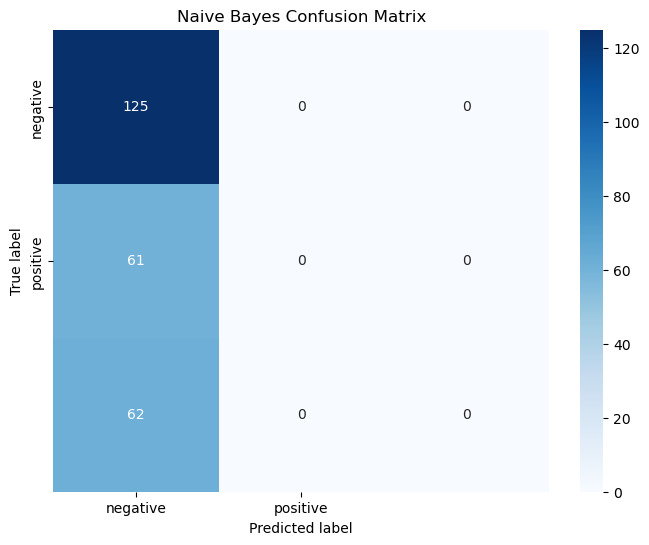

Naive Bayes Classifier Report:
              precision    recall  f1-score   support

    Negative       0.50      1.00      0.67       125
     Neutral       0.00      0.00      0.00        61
    Positive       0.00      0.00      0.00        62

    accuracy                           0.50       248
   macro avg       0.17      0.33      0.22       248
weighted avg       0.25      0.50      0.34       248


Naive Bayes Error Rate: 0.50


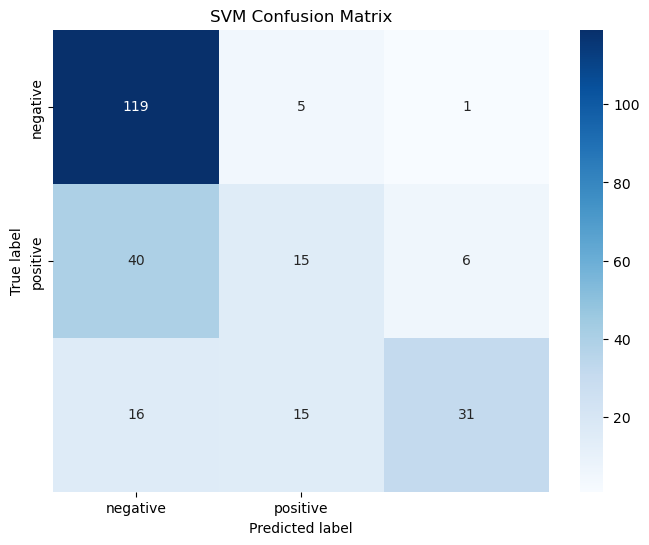


SVM Classifier Report:
              precision    recall  f1-score   support

    Negative       0.68      0.95      0.79       125
     Neutral       0.43      0.25      0.31        61
    Positive       0.82      0.50      0.62        62

    accuracy                           0.67       248
   macro avg       0.64      0.57      0.58       248
weighted avg       0.65      0.67      0.63       248


SVM Error Rate: 0.33


In [35]:
import matplotlib.pyplot as plt
import seaborn as sns

# Function to plot confusion matrix
def plot_confusion_matrix(cm, classes, title='Confusion matrix', cmap=plt.cm.Blues):
    plt.figure(figsize=(8, 6))
    sns.heatmap(cm, annot=True, fmt='d', cmap=cmap, xticklabels=classes, yticklabels=classes)
    plt.title(title)
    plt.xlabel('Predicted label')
    plt.ylabel('True label')
    plt.show()

# Plot confusion matrix for Naive Bayes
plot_confusion_matrix(nb_cm, classes=['negative', 'positive'], title='Naive Bayes Confusion Matrix')

print("Naive Bayes Classifier Report:")
print(nb_report)
print(f"\nNaive Bayes Error Rate: {nb_error_rate:.2f}")

# Plot confusion matrix for SVM
plot_confusion_matrix(svm_cm, classes=['negative', 'positive'], title='SVM Confusion Matrix')

print("\nSVM Classifier Report:")
print(svm_report)
print(f"\nSVM Error Rate: {svm_error_rate:.2f}")